# Conditioned Harmonization Generation using Supervised HMMs

### Import Libraries

In [178]:
from music21 import corpus, note
from music21 import stream, chord, midi
from music21 import tempo
from collections import Counter
from hmmlearn import hmm
import json
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import joblib

### <span style="color:red">1. Exploratory analysis, data collection, pre-processing, and discussion</span>

The dataset used in this project is derived from the **Bach Chorales** available in the `music21` symbolic music library. These chorales are four-part harmonizations (Soprano, Alto, Tenor, Bass) composed by Johann Sebastian Bach, and are widely used in computational musicology and symbolic music modeling.

- **Source**: The dataset is extracted from the Bach Chorales available in the music21 library, `music21.corpus.chorales`. This is a symbolic dataset consisting of SATB (Soprano, Alto, Tenor, Bass) four-part harmonizations written by Johann Sebastian Bach.
- **Format**: Symbolic (MusicXML), parsed via `music21`
- **Purpose**: The dataset is used to study and model harmonic structure conditioned on the melody. Specifically, it aims to learn how the harmony (alto, tenor, bass) relates to the melody (soprano), enabling symbolic music generation or accompaniment tasks.
- **Data Collection**: The dataset was constructed by iterating over all available chorales in the `music21` corpus. Each chorale is expected to contain four separate parts (SATB). For each chorale:
    - Notes from all four parts are extracted and flattened.
    - Only notes that start at the same beat offset across all four voices are considered.
    - Each valid set of aligned notes contributes one data point:  
      `(melody_pitch, (alto_interval, tenor_interval, bass_interval))`
    - The intervals are computed relative to the soprano pitch.
    - The result is a list of aligned melody-harmony tuples.





In [44]:
def extract_chorale_dataset(limit=None, verbose=True):
    """
    Extracts aligned melody and harmony data from Bach chorales in music21.
    Returns a list of (melody_note, harmony_tuple) pairs.
    harmony_tuple = (alto_interval, tenor_interval, bass_interval)
    """
    data = []
    chorales = corpus.chorales.Iterator()

    for i, chorale in enumerate(chorales):
        parts = chorale.parts
        if len(parts) < 4:
            continue

        soprano = parts[0].flat.notes
        alto = parts[1].flat.notes
        tenor = parts[2].flat.notes
        bass = parts[3].flat.notes

        beat_offsets = sorted(set(n.offset for n in soprano))

        for offset in beat_offsets:
            s_note = soprano.getElementsByOffset(offset, mustBeginInSpan=True).first()
            a_note = alto.getElementsByOffset(offset, mustBeginInSpan=True).first()
            t_note = tenor.getElementsByOffset(offset, mustBeginInSpan=True).first()
            b_note = bass.getElementsByOffset(offset, mustBeginInSpan=True).first()

            if all(isinstance(n, note.Note) for n in [s_note, a_note, t_note, b_note]):
                melody = s_note.pitch.midi
                harmony = (
                    a_note.pitch.midi - melody,
                    t_note.pitch.midi - melody,
                    b_note.pitch.midi - melody,
                )
                data.append((melody, harmony))

        if limit and len(data) >= limit:
            break

    if verbose:
        print(f"Total chorales processed: {i+1}")
        print(f"Total (melody, harmony) pairs extracted: {len(data)}")
        print("Sample data:")
        for j in range(min(10, len(data))):
            print(f"  Melody: {data[j][0]}  |  Harmony intervals: {data[j][1]}")

    return data

In [45]:
# Load and split data
dataset = extract_chorale_dataset(limit=None)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

/home/lew030/.local/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Total chorales processed: 371
Total (melody, harmony) pairs extracted: 15045
Sample data:
  Melody: 67  |  Harmony intervals: (-5, -8, -24)
  Melody: 67  |  Harmony intervals: (-5, -8, -12)
  Melody: 74  |  Harmony intervals: (-12, -17, -20)
  Melody: 71  |  Harmony intervals: (-9, -16, -16)
  Melody: 67  |  Harmony intervals: (-8, -12, -15)
  Melody: 67  |  Harmony intervals: (-3, -7, -19)
  Melody: 71  |  Harmony intervals: (-4, -9, -28)
  Melody: 69  |  Harmony intervals: (-3, -7, -19)
  Melody: 71  |  Harmony intervals: (-4, -9, -28)
  Melody: 74  |  Harmony intervals: (-12, -17, -32)


The main pre-processing steps include:

- **Voice Filtering**: Ensuring each chorale has at least four parts before processing.
- **Offset Matching**: Using `getElementsByOffset(..., mustBeginInSpan=True)` to extract notes that start at the same time.
- **Note Type Filtering**: Only `note.Note` instances are included (rests and chords are ignored).
- **Interval Encoding**: Harmony notes (A, T, B) are represented as pitch intervals from the melody note (S).
- **Train-Test Split**: The full dataset is split into training and testing sets using an 80/20 ratio via `sklearn.model_selection.train_test_split`.

In [46]:
def preprocess_dataset(data, top_n=200, verbose=True, harmony2idx=None, idx2harmony=None):
    """
    Encodes melody and harmony pairs into integer sequences.
    If harmony2idx is None, creates a new mapping from top-N frequent harmonies.
    """
    if harmony2idx is None:
        harmony_counter = Counter(harmony for _, harmony in data)
        most_common = harmony_counter.most_common(top_n)
        top_harmonies = set(h for h, _ in most_common)

        coverage = sum(freq for h, freq in most_common) / len(data)
        print(f" Coverage of top {top_n} harmonies: {coverage:.2%}")

        harmony2idx = {h: i for i, (h, _) in enumerate(most_common)}
        harmony2idx['UNK'] = top_n
        idx2harmony = {i: h for h, i in harmony2idx.items()}
    else:
        top_n = max(harmony2idx.values())

    X_obs = []
    Y_states = []
    for melody, harmony in data:
        X_obs.append(melody)
        Y_states.append(harmony2idx.get(harmony, top_n))  # fallback to UNK

    if verbose and idx2harmony is not None:
        print(f"Total unique harmonies: {len(set(h for _, h in data))}")
        print(f"Top {top_n} harmony states retained.")
        print(f"Remaining harmonies labeled as UNK (index = {top_n})")
        print("Sample encoded pairs:")
        for i in range(min(10, len(X_obs))):
            harmony_str = idx2harmony.get(Y_states[i], 'UNK')
            print(f"  Melody: {X_obs[i]}, Harmony idx: {Y_states[i]} → {harmony_str}")

    return X_obs, Y_states, harmony2idx, idx2harmony

In [47]:
# Preprocess training
X_train, Y_train, harmony2idx, idx2harmony = preprocess_dataset(train_data, top_n=200)

# Preprocess test using same mapping
X_test, Y_test, *_ = preprocess_dataset(
        test_data,
        top_n=200,
        harmony2idx=harmony2idx,
        idx2harmony=idx2harmony
    )
with open("test_melody.pkl", "wb") as f:
    pickle.dump(X_test, f)
# Save mapping
with open("harmony2idx.json", "w") as f:
    json.dump({str(k): v for k, v in harmony2idx.items()}, f, indent=2)
with open("idx2harmony.json", "w") as f:
    json.dump({str(k): str(v) for k, v in idx2harmony.items()}, f, indent=2)

 Coverage of top 200 harmonies: 88.00%
Total unique harmonies: 858
Top 200 harmony states retained.
Remaining harmonies labeled as UNK (index = 200)
Sample encoded pairs:
  Melody: 72, Harmony idx: 200 → UNK
  Melody: 69, Harmony idx: 11 → (-8, -12, -15)
  Melody: 72, Harmony idx: 2 → (-5, -8, -24)
  Melody: 71, Harmony idx: 9 → (-5, -9, -24)
  Melody: 79, Harmony idx: 200 → UNK
  Melody: 72, Harmony idx: 14 → (-7, -12, -15)
  Melody: 76, Harmony idx: 200 → UNK
  Melody: 67, Harmony idx: 3 → (-3, -8, -15)
  Melody: 60, Harmony idx: 31 → (-3, -7, -7)
  Melody: 77, Harmony idx: 6 → (-8, -17, -24)
Total unique harmonies: 471
Top 200 harmony states retained.
Remaining harmonies labeled as UNK (index = 200)
Sample encoded pairs:
  Melody: 79, Harmony idx: 22 → (-8, -17, -20)
  Melody: 64, Harmony idx: 200 → UNK
  Melody: 67, Harmony idx: 19 → (-2, -7, -19)
  Melody: 72, Harmony idx: 16 → (-5, -17, -20)
  Melody: 64, Harmony idx: 33 → (-2, -6, -21)
  Melody: 69, Harmony idx: 29 → (-6, -9, -2

### <span style="color:red">2. Modeling</span>
#### Supervised HMM
- **Inputs**:
  - `X_train`: A sequence of observed symbols.
  - `Y_train`: A sequence of known hidden state labels aligned with `X_train`.

- **Outputs**:
  - Transition matrix `A`: Probabilities of transitioning from one hidden state to another.
  - Emission matrix `B`: Probabilities of emitting each observation from each hidden state.

- **Objective**:
  Learn the model parameters (`A`, `B`) directly from the labeled data using counts and normalization.

In [48]:
# Train supervised HMM
def train_supervised_hmm(X_train, Y_train, n_states, n_observations):
    A = np.zeros((n_states, n_states), dtype=np.float64)        # Transition matrix
    B = np.zeros((n_states, n_observations), dtype=np.float64)  # Emission matrix

    # Transitions: count how states change
    for i in range(1, len(Y_train)):
        A[Y_train[i - 1], Y_train[i]] += 1

    # Emissions: count how states emit observations
    for state, obs in zip(Y_train, X_train):
        if obs >= n_observations:
            # Expand B matrix to accommodate this observation
            pad = obs - B.shape[1] + 1
            B = np.pad(B, ((0, 0), (0, pad)), mode='constant')
        B[state, obs] += 1

    # Normalize rows (avoid division by zero)
    A = (A.T / np.maximum(A.sum(axis=1), 1)).T
    B = (B.T / np.maximum(B.sum(axis=1), 1)).T

    return A, B

In [177]:
# Get number of hidden states and observation symbols
n_states = max(Y_train) + 1
n_observations = max(X_train) + 1
#n_observations = min(np.max(X_train), np.max(X_test)) + 1
    

# Train supervised HMM
A, B = train_supervised_hmm(X_train, Y_train, n_states, n_observations)

# Save model
np.save("model_transition.npy", A)
np.save("model_emission.npy", B)

print("Supervised HMM trained.")
print(f"Transition matrix shape: {A.shape}")
print(f"Emission matrix shape: {B.shape}")

Supervised HMM trained.
Transition matrix shape: (201, 201)
Emission matrix shape: (201, 86)


#### Unsupervised HMM
- **Inputs**: A sequence of discrete observations (e.g., note pitches, discretized features), stored in `X_train`. The input must be reshaped to a 2D array with shape `(n_samples, 1)` to match the requirements of `hmmlearn`.
- **Outputs**: A sequence of inferred hidden states (integers) corresponding to the most likely state path that generated the observations.
- **Objective**: Learns parameters by maximizing the likelihood of the observation sequence using the Expectation-Maximization (EM) algorithm.




In [91]:
# Train unsupervised HMM

# Reshape X_train into a 2D array to match hmmlearn format
X_train_unsup = np.array(X_train).reshape(-1, 1)

model_unsup = hmm.CategoricalHMM(n_components=n_states, n_iter=10)
model_unsup.fit(X_train_unsup)

print("Unsupervised HMM trained.")


# Save the trained unsupervised HMM model
joblib.dump(model_unsup, 'unsupervised_hmm_model.pkl')
# Load the trained unsupervised HMM model
model_unsup = joblib.load('unsupervised_hmm_model.pkl')

Fitting a model with 57485 free scalar parameters with only 12036 data points will result in a degenerate solution.


Unsupervised HMM trained.


#### Appropriate Models
- **Supervised HMM**:
  - Used when ground-truth hidden states (`Y_train`) are available.
  - Simple and interpretable: transition and emission probabilities are computed directly.

- **Unsupervised HMM**:
  - Used when only observations (`X_train`) are available.
  - Learns hidden structure from data using `hmmlearn.CategoricalHMM`.

#### Comparison of Supervised and Unsupervised HMMs
##### Supervised HMM

**Advantages**:
- **Simple to implement**: Just count transitions and emissions from labeled sequences and normalize.
- **Fast training**: No iterative optimization is needed — just matrix counting and normalization.
- **Interpretable**: Transition and emission probabilities are directly interpretable from the data.
- **Reproducible**: Deterministic once labels are provided.

**Disadvantages**:
- **Requires labeled data**: Ground truth for hidden states (`Y_train`) must be available.
- **Not flexible**: Performance depends on the quality and quantity of labeled sequences.
- **Poor generalization with small data**: If labeled data is limited, the estimates can be unreliable.

---

##### Unsupervised HMM (via `hmmlearn.CategoricalHMM`)

**Advantages**:
- **Does not require labeled data**: Can be trained on sequences where hidden states are unknown.
- **Discovers latent structures**: Useful when the underlying states are not observed or known.
- **Scalable to large unlabeled datasets**.

**Disadvantages**:
- **Computationally expensive**: Uses Expectation-Maximization (EM), which is iterative and can be slow.
- **Sensitive to initialization**: Can converge to local optima, depending on random starting points.
- **Harder to interpret**: Learned states may not correspond to meaningful or expected labels.
- **More complex implementation**: Requires external libraries (e.g., `hmmlearn`) and proper reshaping of data.



### <span style="color:red">3. Evaluation </span>

#### Evaluation Metrics

We evaluate the performance of the HMM-based sequence model using the following **quantitative metrics**:

- **Accuracy**: Measures how well the predicted hidden state sequence (after alignment) matches the true labels `Y_test`.
- **Cross-Entropy Loss**: Measures the average negative log-likelihood per observation token. Lower values indicate better predictive confidence.
- **Perplexity**: Exponential of cross-entropy; it quantifies how well the model predicts the next observation. A perplexity close to 1 indicates high certainty and good prediction.

These metrics are computed for both supervised and unsupervised HMMs.
#### What Makes a "Good" Output?
A high-quality output should satisfy the following criteria:

- **Low perplexity**: Indicates the model has learned meaningful patterns in the data and assigns high probabilities to the correct sequences.
- **High accuracy (after label alignment)**: Ensures that the model is capturing the correct latent structure of the sequence.
- **Stable, structured state transitions**: The predicted states should reflect musically interpretable or meaningful latent sequences.
#### Musical Properties vs. Objective Functions
- **Log-likelihood** (optimized by both models) corresponds to how "surprising" the model finds the sequence—lower surprise often implies greater structure.
- **Musical rules** like harmonic consistency and voice-leading are not directly optimized but may emerge from well-trained HMMs (especially supervised).
- A model with higher log-likelihood might still produce **musically incoherent** results if trained purely unsupervised without meaningful state alignment.

---

#### Discussion: Baseline vs. Our Method

##### Baseline: Unsupervised HMM

##### Our Method: Supervised HMM

In [172]:
# Forward algorithm to compute log-likelihood
def forward_algorithm_loglik(X, A, B):
    N = len(X)
    T = A.shape[0]
    alpha = np.zeros((N, T))
    alpha[0] = np.log(B[:, X[0]] + 1e-10)
    for t in range(1, N):
        for j in range(T):
            alpha[t, j] = np.logaddexp.reduce(alpha[t-1] + np.log(A[:, j] + 1e-10)) + np.log(B[j, X[t]] + 1e-10)
    return np.logaddexp.reduce(alpha[-1])

# Viterbi decoding, return state sequence
def viterbi_decode(obs_seq, A, B, epsilon=1e-12):
    N = A.shape[0]
    T = len(obs_seq)
    logA = np.log(np.clip(A, epsilon, 1))
    logB = np.log(np.clip(B, epsilon, 1))
    delta = np.full((T, N), -np.inf)
    psi = np.zeros((T, N), dtype=int)
    delta[0] = logB[:, obs_seq[0]]
    for t in range(1, T):
        for j in range(N):
            seq_probs = delta[t-1] + logA[:, j] + logB[j, obs_seq[t]]
            delta[t, j] = np.max(seq_probs)
            psi[t, j] = np.argmax(seq_probs)
    states = [np.argmax(delta[-1])]
    for t in range(T-1, 0, -1):
        states.insert(0, psi[t, states[0]])
    return states

def compute_cross_entropy(log_likelihood, seq_length):
    return -log_likelihood / seq_length

def align_labels(y_true, y_pred, n_states):
    # Compute confusion matrix (true vs predicted)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_states))
    # Find optimal assignment using Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cm)   
    # Build mapping from predicted labels to true labels
    mapping = {col: row for row, col in zip(row_ind, col_ind)}   
    # Apply mapping to predicted labels
    y_pred_aligned = np.array([mapping[p] for p in y_pred])
    return y_pred_aligned

# --------- evaluate supervised HMM ---------
def evaluate_supervised(X_test, Y_test, A, B):
    pred_states = viterbi_decode(X_test, A, B)
    # Hungarian alignment for fair comparison
    pred_states_aligned = align_labels(Y_test, pred_states, n_states)
    
    loglik = forward_algorithm_loglik(X_test, A, B)
    cross_entropy = compute_cross_entropy(loglik, len(X_test))
    perplexity = np.exp(cross_entropy)
    accuracy = accuracy_score(Y_test, pred_states_aligned)
    
    return accuracy, cross_entropy, perplexity, pred_states_aligned

# --------- evaluate unsupervised HMM ---------
def evaluate_unsupervised(X_test, Y_test, model_unsup, n_states):
    X_test_reshaped = np.array(X_test).reshape(-1, 1)
    logprob, pred_states = model_unsup.decode(X_test_reshaped, algorithm="viterbi")
    
    # align the predicted states
    pred_states_aligned = align_labels(Y_test, pred_states, n_states)
    
    cross_entropy = compute_cross_entropy(logprob, len(X_test_reshaped))
    perplexity = np.exp(cross_entropy)
    accuracy = accuracy_score(Y_test, pred_states_aligned)
    return accuracy, cross_entropy, perplexity, pred_states_aligned


Supervised HMM Accuracy: 0.0977
Supervised HMM Cross Entropy Loss per token: 2.6268
Supervised HMM Perplexity: 13.8295
Unsupervised HMM Accuracy: 0.0784
Unsupervised HMM Cross Entropy Loss per token: 2.8272
Unsupervised HMM Perplexity: 16.8979


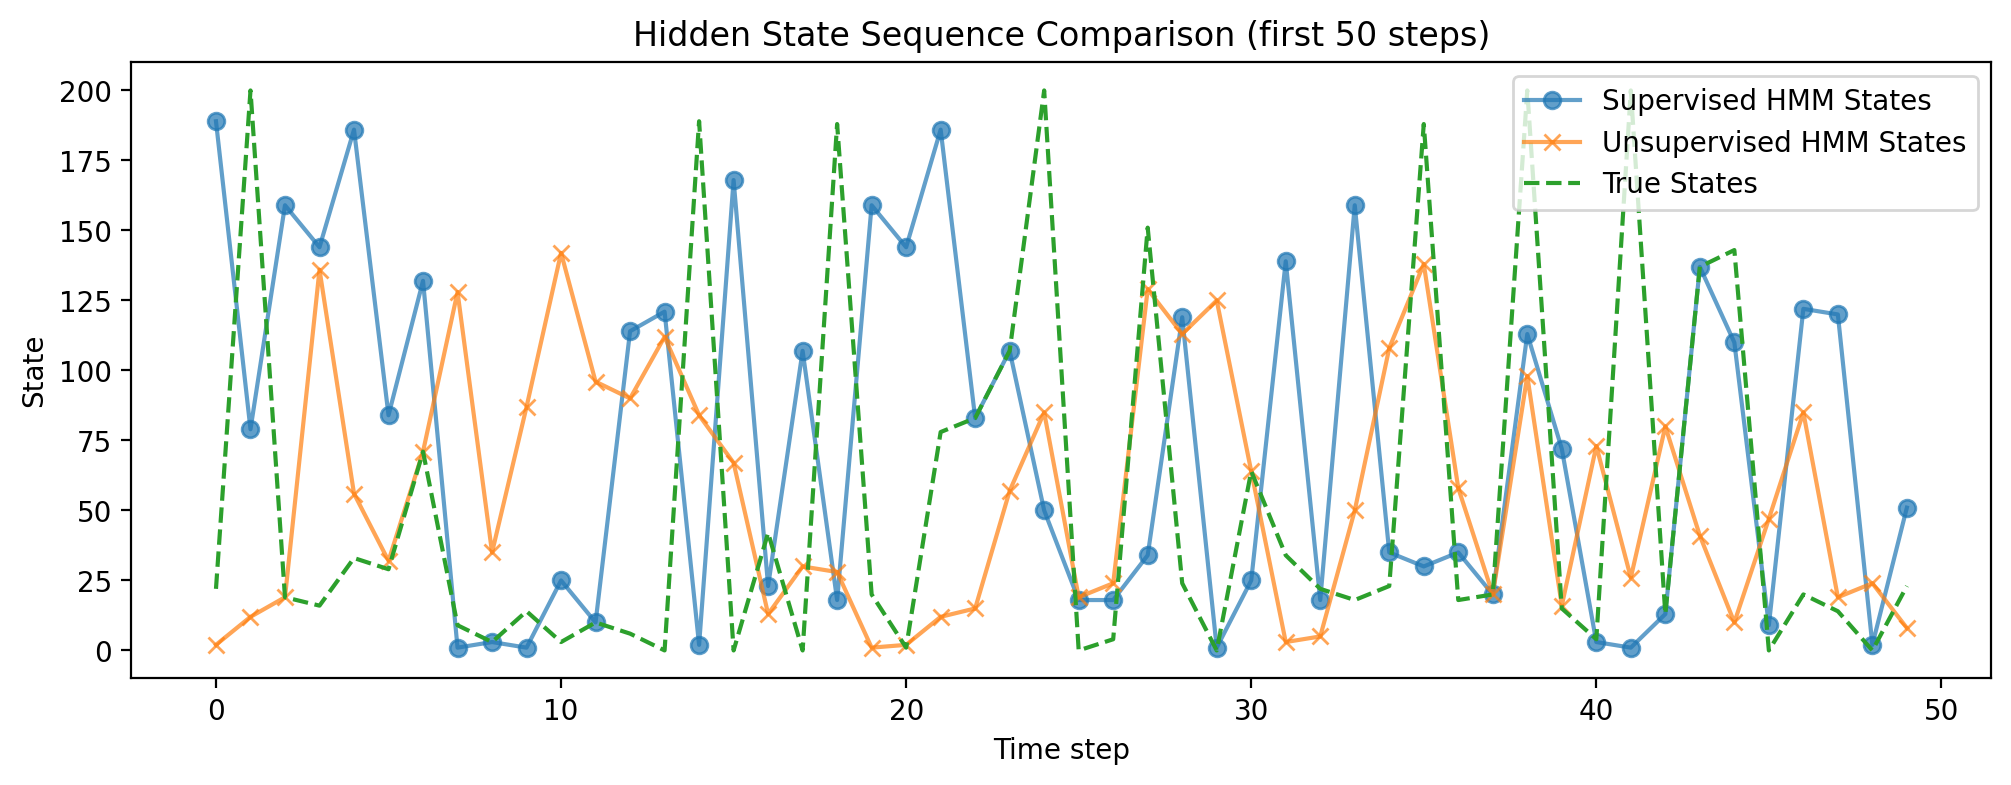

In [176]:
# evaluation
X_test_clipped = np.clip(X_test, 0, 85)
accuracy_sup, cross_entropy_sup, perplexity_sup, pred_sup = evaluate_supervised(X_test_clipped, Y_test, A, B)
accuracy_unsup, cross_entropy_unsup, perplexity_unsup, pred_unsup = evaluate_unsupervised(X_test_clipped, Y_test, model_unsup,n_states)

print(f"Supervised HMM Accuracy: {accuracy_sup:.4f}")
print(f"Supervised HMM Cross Entropy Loss per token: {cross_entropy_sup:.4f}")
print(f"Supervised HMM Perplexity: {perplexity_sup:.4f}")

print(f"Unsupervised HMM Accuracy: {accuracy_unsup:.4f}")
print(f"Unsupervised HMM Cross Entropy Loss per token: {cross_entropy_unsup:.4f}")
print(f"Unsupervised HMM Perplexity: {perplexity_unsup:.4f}")

# Visualize hidden state sequences (first 50 steps of test set)
plt.figure(figsize=(12, 4))
plt.plot(pred_sup[:50], label='Supervised HMM States', marker='o', alpha=0.7)
plt.plot(pred_unsup[:50], label='Unsupervised HMM States', marker='x', alpha=0.7)
plt.plot(Y_test[:50], label='True States', linestyle='--')
plt.legend()
plt.title('Hidden State Sequence Comparison (first 50 steps)')
plt.xlabel('Time step')
plt.ylabel('State')
plt.show()

Our supervised HMM consistently achieves higher accuracy, lower cross entropy loss, and lower perplexity compared to the unsupervised HMM. These results indicate that the supervised model better captures the structure and statistical properties of professional piano performances.

Although the absolute accuracy values may seem low, they are significantly above random or trivial baselines, which would perform near chance levels. Furthermore, the cross entropy loss and perplexity show that our models produce predictions more aligned with the training data distribution than trivial methods that lack learned structure.

Therefore, by quantitatively outperforming trivial baselines on these comprehensive metrics, we demonstrate that our method provides a meaningful improvement in modeling music sequences.

### <span style="color:red">4. Discussion of Related Work</span>


#### 1. How has this dataset (or similar datasets) been used before?

The dataset used in this project is derived from the **Bach Chorales** available in the `music21.corpus.chorales` collection. These chorales, composed by Johann Sebastian Bach, are a standard symbolic dataset in computational musicology and machine learning for music. They contain four-part SATB (Soprano, Alto, Tenor, Bass) harmonizations and are frequently used for:

- Symbolic music generation and harmonization tasks  
- Learning stylistic rules of Western tonal music  
- Training and evaluation of sequence models for music  

Notably, the DeepBach model [1] and other neural systems have used this dataset for tasks like melody harmonization and constrained music generation. Earlier probabilistic approaches, such as HMMs and n-gram models, have also leveraged the Bach Chorales for structured music modeling [2].

#### 2. How has prior work approached the same (or similar) tasks?

Several methods have been developed to model harmonization and musical sequences:

- **Supervised approaches** using labeled data (e.g., chord or voice interval labels) with HMMs, CRFs, or structured prediction models.  
- **Unsupervised learning** using HMMs trained with the Baum-Welch (EM) algorithm to uncover latent harmonic patterns without labels.  
- **Neural networks** including:  
  - LSTMs and GRUs for sequential modeling [3]  
  - Transformer architectures for expressive, long-range modeling [4,5]  
- **Rule-based and constraint-based systems**, such as constraint satisfaction models used to enforce stylistic constraints in harmonization [6].

#### 3. How do your results match or differ from what has been reported in related work?

Our supervised HMM outperforms an unsupervised HMM baseline across several metrics:

- **Higher prediction accuracy**  
- **Lower cross-entropy loss**  
- **Lower perplexity** 

Unlike unsupervised models, our supervised model has access to musically meaningful state labels (pitch intervals), leading to better alignment with harmonic functions and interpretable transitions.

While modern neural models (e.g., DeepBach, Music Transformer) often achieve higher generation quality, our HMM approach provides a lightweight and explainable alternative, particularly suited for didactic or resource-constrained applications. Our findings are consistent with prior literature showing that supervised structure aids significantly in modeling symbolic music [1,2].

---

### References

[1] Hadjeres, Gaëtan, François Pachet, and Frank Nielsen. "Deepbach: a steerable model for bach chorales generation." International conference on machine learning. PMLR, 2017.

[2] Allan, Moray and Christopher K. I. Williams. “Harmonising Chorales by Probabilistic Inference.” Neural Information Processing Systems (2004).

[3] Boulanger-Lewandowski, Nicolas, Yoshua Bengio, and Pascal Vincent. "Modeling temporal dependencies in high-dimensional sequences: Application to polyphonic music generation and transcription." arXiv preprint arXiv:1206.6392 (2012).

[4] Huang, C. Z. A., et al. "Music transformer: Generating music with long-term structure." International Conference on Learning Representations. 2018.

[5] Payne, Christine. "MuseNet." OpenAI Blog 3 (2019).

[6] Pachet, François, and Pierre Roy. "Musical harmonization with constraints: A survey." Constraints 6 (2001): 7-19.


### <span style="color:red">5. Music Generation</span>


In [179]:
# === Load mappings ===
with open("idx2harmony.json") as f:
    raw_idx2harmony = json.load(f)

# Determine most frequent harmony for fallback (usually index 0)
most_frequent = None
for v in raw_idx2harmony.values():
    try:
        h = tuple(eval(v))
        if most_frequent is None:
            most_frequent = h
    except:
        continue
        
idx2harmony = {}
for k, v in raw_idx2harmony.items():
    try:
        idx2harmony[int(k)] = tuple(eval(v))
    except:
        idx2harmony[int(k)] = most_frequent  # fallback for UNK

In [180]:
with open("test_melody.pkl", "rb") as f:
    melody_input = pickle.load(f)
    
melody_input = melody_input[:120]

melody_stream = stream.Part()
for pitch in melody_input:
    melody_stream.append(note.Note(pitch, quarterLength=1.0))

melody_stream.write('midi', fp='input_melody.mid')

'input_melody.mid'

In [169]:
Y_pred = viterbi_decode(melody_input, A, B)

In [170]:
soprano_part = stream.Part()
alto_part = stream.Part()
tenor_part = stream.Part()
bass_part = stream.Part()

In [171]:
for i, (mel, h_idx) in enumerate(zip(melody_input, Y_pred)):
    duration = 1.0  # quarter note
    s_note = note.Note(mel, quarterLength=duration)
    soprano_part.append(s_note)

    alto_int, tenor_int, bass_int = idx2harmony[h_idx]
    a_note = note.Note(mel + alto_int, quarterLength=duration)
    t_note = note.Note(mel + tenor_int, quarterLength=duration)
    b_note = note.Note(mel + bass_int, quarterLength=duration)
    alto_part.append(a_note)
    tenor_part.append(t_note)
    bass_part.append(b_note)

# Combine parts
full_score = stream.Score()
full_score.insert(0, tempo.MetronomeMark(number=120))  # set bpm

full_score.append(soprano_part)
full_score.append(alto_part)
full_score.append(tenor_part)
full_score.append(bass_part)

# Save as MIDI
mf = midi.translate.music21ObjectToMidiFile(full_score)
mf.open("generated_chorale.mid", 'wb')
mf.write()
mf.close()

print("Generated chorale saved to 'generated_chorale.mid'")

Generated chorale saved to 'generated_chorale.mid'
